# **MODELING FOR THE DAI-USDC-USDT POOL**

# **Imports**

In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
sns.set(style="darkgrid")
sns.set_palette("husl")
scaler = MinMaxScaler(feature_range=(-1, 1))
torch.manual_seed(27)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

device

'cpu'

# **Initializing**

In [2]:
def read_and_preprocess_csv(file_path, date_column, rename_to=""):
    if rename_to == "":
        df = pd.read_csv(file_path, parse_dates=[date_column])
        df[date_column] = df[date_column].dt.tz_localize(None).dt.date
        return df
    else:
        df = pd.read_csv(file_path, parse_dates=[date_column])
        df.rename(columns={"snapped_at": "DATE"}, inplace=True)
        df[rename_to] = pd.to_datetime(df[rename_to].dt.tz_localize(None).dt.date)
        return df


dtc1 = read_and_preprocess_csv("DATA/DAI-USDC-USDT.csv", "DATE")
dtc2 = read_and_preprocess_csv("DATA/DAI-USDC-USDT2.csv", "DATE")

usdt = read_and_preprocess_csv("DATA/usdt-usd-max.csv", "snapped_at", "DATE")
usdc = read_and_preprocess_csv("DATA/usdc-usd-max.csv", "snapped_at", "DATE")
dai = read_and_preprocess_csv("DATA/dai-usd-max.csv", "snapped_at", "DATE")

In [3]:
DTC = pd.merge(dtc1, dtc2, on="DATE")
DTC.drop(["APY_BASE", "APY_REWARD"], axis=1, inplace=True)
DTC["DATE"] = pd.to_datetime(DTC["DATE"])

In [4]:
usdt = usdt.add_suffix("_usdt")
usdc = usdc.add_suffix("_usdc")
dai = dai.add_suffix("_dai")
DTC = DTC.add_suffix("_pool")

In [5]:
merged_df = pd.merge(usdt, usdc, how="right", left_on="DATE_usdt", right_on="DATE_usdc")
merged_df = pd.merge(
    merged_df, dai, how="right", left_on="DATE_usdt", right_on="DATE_dai"
)
merged_df.drop(["DATE_usdc", "DATE_dai"], inplace=True, axis=1)
pool_data = pd.merge(
    DTC, merged_df, how="left", right_on="DATE_usdt", left_on="DATE_pool"
)
pool_data.rename(columns={"DATE_usdt": "DATE"}, inplace=True)
pool_data.drop(["DATE_pool"], inplace=True, axis=1)

In [6]:
pool_data["Day of Week"] = pool_data["DATE"].dt.dayofweek
pool_data["Day"] = pool_data["DATE"].dt.day
pool_data["Year"] = pool_data["DATE"].dt.year
pool_data["Month"] = pool_data["DATE"].dt.month

pool_data.set_index("DATE", inplace=True)

# **Preprocessing**

In [7]:
def prepare_dataframe_for_lstm(df, n_steps, columns=[]):
    df = dc(df)

    for i in range(1, n_steps + 1):
        df[f"TV(t-{i})"] = df[columns[0]].shift(i)
        df[f"TVL(t-{i})"] = df[columns[1]].shift(i)
    df.dropna(inplace=True)

    return df


lookback = 7
shifted_df = prepare_dataframe_for_lstm(
    pool_data, lookback, ["TOTAL_TRADING_VOLUME_USD_pool", "TVL_pool"]
)

In [8]:
columns_to_exclude = [
    "APY_pool",
    "TVL_pool",
    "SWAP_COUNT_pool",
    "price_usdt",
    "market_cap_usdt",
    "total_volume_usdt",
    "price_usdc",
    "market_cap_usdc",
    "total_volume_usdc",
    "price_dai",
    "market_cap_dai",
    "total_volume_dai",
    "Day of Week",
    "Day",
    "Year",
    "Month",
]

shifted_df = shifted_df.drop(columns=columns_to_exclude)

In [9]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((632, 14), (632,))

In [11]:
X = dc(np.flip(X, axis=1))

In [12]:
split_index = int(len(X) * 0.92)
split_index

581

# **Data Preparation**

In [13]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((581, 14), (51, 14), (581,), (51,))

In [14]:
X_train = X_train.reshape((-1, 14, 1))
X_test = X_test.reshape((-1, 14, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((581, 14, 1), (51, 14, 1), (581, 1), (51, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([581, 14, 1]),
 torch.Size([51, 14, 1]),
 torch.Size([581, 1]),
 torch.Size([51, 1]))

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([2, 14, 1]) torch.Size([2, 1])


# **Modelling**

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_stacked_layers, batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(
            device
        )
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(
            device
        )

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

# **Model Training**

In [20]:
def train_one_epoch():
    model.train()
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: 
            avg_loss_across_batches = running_loss / 100
            print(
                "Batch {0}, Loss: {1:.3f}".format(
                    batch_index + 1, avg_loss_across_batches
                )
            )
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.inference_mode():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print("Val Loss: {0:.5f}".format(avg_loss_across_batches))
    print("***************************************************")
    print()

In [22]:
learning_rate = 0.001
num_epochs = 60
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.129
Batch 200, Loss: 0.012

Val Loss: 0.00147
***************************************************

Epoch: 2
Batch 100, Loss: 0.016
Batch 200, Loss: 0.006

Val Loss: 0.00042
***************************************************

Epoch: 3
Batch 100, Loss: 0.027
Batch 200, Loss: 0.008

Val Loss: 0.00015
***************************************************

Epoch: 4
Batch 100, Loss: 0.024
Batch 200, Loss: 0.012

Val Loss: 0.00013
***************************************************

Epoch: 5
Batch 100, Loss: 0.010
Batch 200, Loss: 0.022

Val Loss: 0.00092
***************************************************

Epoch: 6
Batch 100, Loss: 0.002
Batch 200, Loss: 0.029

Val Loss: 0.00020
***************************************************

Epoch: 7
Batch 100, Loss: 0.010
Batch 200, Loss: 0.023

Val Loss: 0.00015
***************************************************

Epoch: 8
Batch 100, Loss: 0.005
Batch 200, Loss: 0.024

Val Loss: 0.00142
*************************************

# **Model Evaluation**

In [23]:
model.eval()
running_loss = 0.0

for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.inference_mode():
        model.eval()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

avg_loss_across_batches = running_loss / len(test_loader)

print("Val Loss: {0:.5f}".format(avg_loss_across_batches))
print("***************************************************")

Val Loss: 0.00014
***************************************************


In [24]:
with torch.inference_mode():
    model.eval()
    predicted = model(X_train.to(device)).detach().cpu().numpy()

In [25]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 14+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

In [26]:
dummies = np.zeros((X_train.shape[0], 14 + 1))

dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

y_train = dc(dummies[:, 0])

In [27]:
y_train = y_train.squeeze()
train_predictions = train_predictions.squeeze()

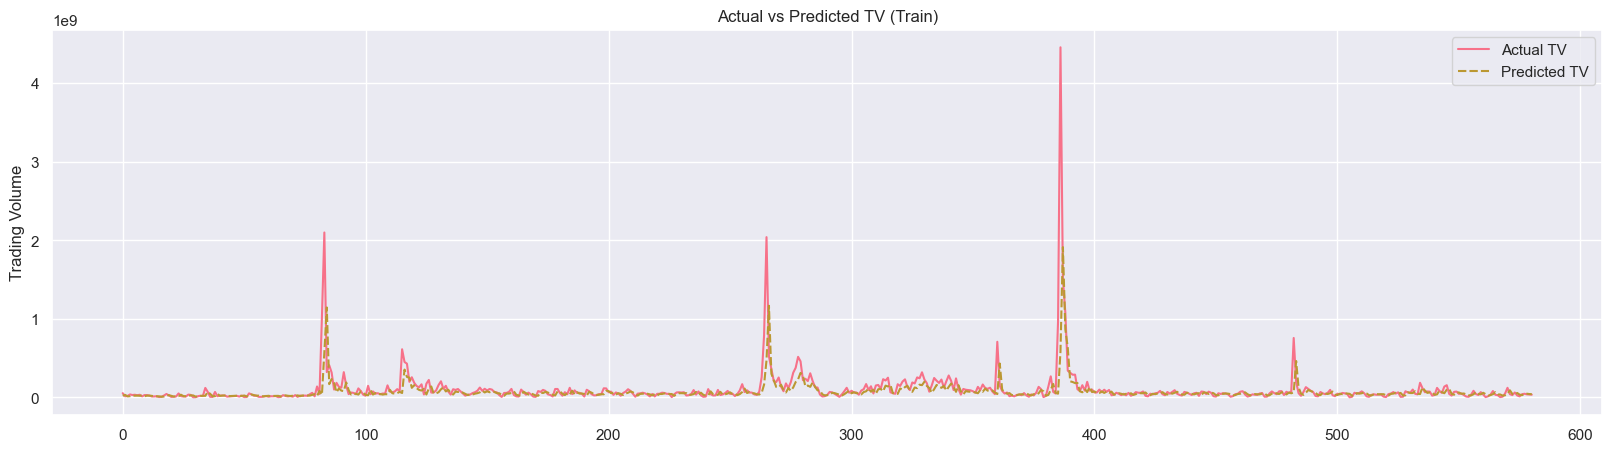

In [28]:
train_df_plot = pd.DataFrame({'Actual TV': y_train, 'Predicted TV': train_predictions})


sns.set(style="darkgrid")
sns.set_palette("husl")
plt.figure(figsize=(20, 5))
sns.lineplot(data=train_df_plot)
plt.ylabel('Trading Volume')
plt.title('Actual vs Predicted TV (Train)')
plt.show()

In [29]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [30]:
with torch.inference_mode():
    model.eval()
    test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 14 + 1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])

In [31]:
dummies = np.zeros((X_test.shape[0], 14 + 1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

y_test = dc(dummies[:, 0])

In [32]:
y_test = y_test.squeeze()
test_predictions = test_predictions.squeeze()

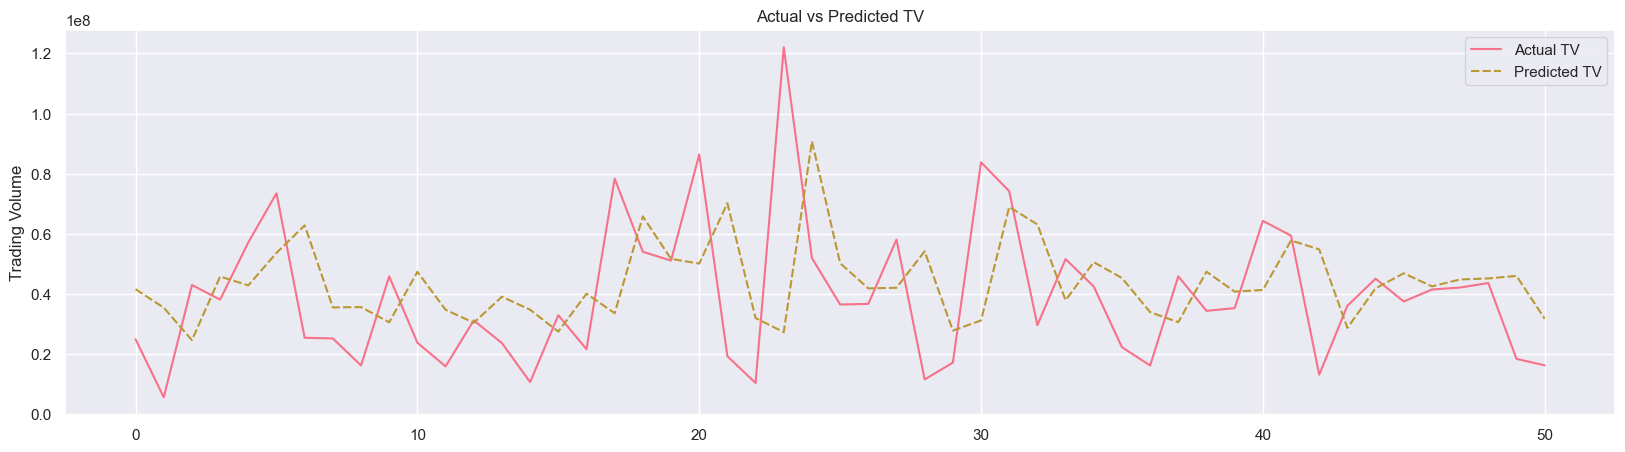

In [33]:
df_plot = pd.DataFrame({'Actual TV': y_test, 'Predicted TV': test_predictions})

plt.figure(figsize=(20, 5))
sns.lineplot(data=df_plot)
plt.ylabel('Trading Volume')
plt.title('Actual vs Predicted TV')
plt.show()

In [390]:
torch.save(model.state_dict(), "best_model.pt")